In [1]:
import sys
import os
import numpy as np
import random as rn
import pandas as pd
import torch
torch.cuda.current_device()
from pytorch_pretrained_bert import BertModel
from torch import nn

# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.

from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

### data loading

In [3]:
path_pos = '../data/movie_reviews/train/pos/'
path_neg = '../data/movie_reviews/train/neg/'


# read negative reviews
files = [f for f in os.listdir(path_neg)]
df_neg = pd.concat([pd.read_csv(os.path.join(path_neg, fp), sep='\n', header=None) for fp in files[:1000]])
df_neg.index = np.arange(df_neg.size) # set the index to ascending (before all 0's)
df_neg.columns = ['text'] # add proper header
df_neg['id'] = 0 # labels=0 (negative)
df_neg = df_neg[['id', 'text']] # rearange

print(df_neg)
print(df_neg.size)

# read positive reviews
files = [f for f in os.listdir(path_pos)]
df_pos = pd.concat([pd.read_csv(os.path.join(path_pos, fp), sep='\n', header=None) for fp in files[:1000]])
df_pos.index = np.arange(df_pos.size)
df_pos.columns = ['text']
df_pos['id'] = 1 # labels=1 (positive)
df_pos = df_pos[['id', 'text']]

print(df_pos)
print(df_pos.size)

# concat pos& neg reviews and shuffle
df = pd.concat([df_pos, df_neg])
df = df.sample(frac=1).reset_index(drop=True)

print(df)
print(df.size)

     id                                               text
0     0  I wasn't really going to comment, but then I f...
1     0  The final pairing of Nelson Eddy and Jeanette ...
2     0  An intriguing premise of hand-drawn fantasy co...
3     0  I bought this DVD for £1 and now i realise why...
4     0  I did not expect much from this film, but boy-...
..   ..                                                ...
995   0  First off, the lead, Brad Dourif is a KOOK. If...
996   0  The perfect murder is foiled when a wife(playe...
997   0  The explosion of TV channels must be eternally...
998   0  I just saw this movie on Flix after timer-tapi...
999   0  They had such potential for this movie and the...

[1000 rows x 2 columns]
2000
     id                                               text
0     1  The next-to-last episode aired of the original...
1     1  In 1942 a film TALES OF MANHATTAN told a set o...
2     1  Financially strapped Paramount pulled out all ...
3     1  This movie has ma

In [4]:
# dataframe -> dict
train_data = df[:1000].to_dict(orient='records') # have been shuffled in previous step
valid_data = df[1000:].to_dict(orient='records')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #

In [5]:
# split into text (input) and labels (output)
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['id']), train_data)))
valid_texts, valid_labels = list(zip(*map(lambda d: (d['text'], d['id']), valid_data)))

len(train_texts), len(train_labels), len(valid_texts), len(valid_labels)

(1000, 1000, 1000, 1000)

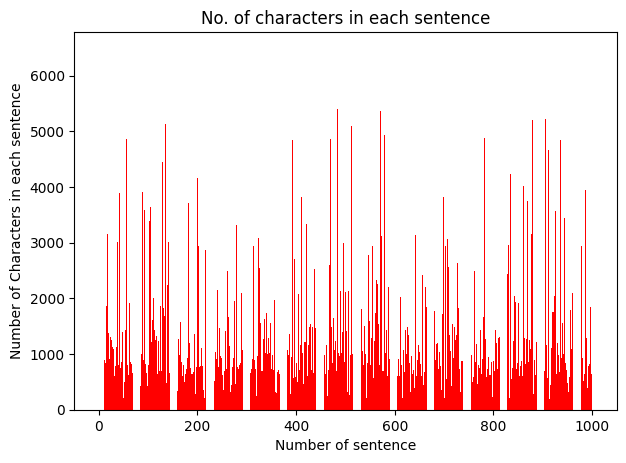

In [7]:
# analysis of review length
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,1001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');



In [8]:
# bert tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [9]:
# illustrate tokenizer
tokenizer.tokenize('Hi my name is Atul')

['hi', 'my', 'name', 'is', 'at', '##ul']

In [10]:
# token embeddings with required separation token
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
valid_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], valid_texts))

len(train_tokens), len(valid_tokens)

(1000, 1000)

In [11]:
# prepare token ids: each token (word fragment) corresponds to an id in the bert corpus
# further need to make all review the same length -> padding too short, truncating too long ones
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
valid_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, valid_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, valid_tokens_ids.shape

((1000, 512), (1000, 512))

In [12]:
# mask for padding (don't know why this is needed)
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
valid_masks = [[float(i > 0) for i in ii] for ii in valid_tokens_ids]



### Baseline

In [13]:
# load sklearn library
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [14]:
# features=countvectorizer, logistic regression on top of it
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)),
                               LogisticRegression()).fit(train_texts, train_labels)

In [15]:
baseline_predicted = baseline_model.predict(valid_texts)

In [16]:
print(classification_report(valid_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       507
           1       0.78      0.84      0.81       493

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.80      1000
weighted avg       0.81      0.81      0.80      1000



### BERT Model

In [17]:
# bert model class
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba



In [18]:
# allocate on gpu
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
# put bert on gpu
bert_clf = BertBinaryClassifier().to(device)
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

439.065088M


In [20]:
# push one review through bert and observe memory consumption
x = torch.tensor(train_tokens_ids[:1]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False) # embedding (768) before final classification layer
x.shape, y.shape, pooled.shape
print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')

1499.110912M


In [21]:
# classifier
y = bert_clf(x)
y.cpu().detach().numpy() 

array([[0.4131659]], dtype=float32)

In [22]:
# clean up space
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'439.065088M'

### Fine Tune Bert

In [28]:
# Setting hyper-parameters
BATCH_SIZE = 1
EPOCHS = 5

In [29]:
# transform (input, output) to torch tensor
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_labels_tensor = torch.tensor(np.array(train_labels).reshape(-1, 1)).float()

valid_tokens_tensor = torch.tensor(valid_tokens_ids)
valid_labels_tensor = torch.tensor(np.array(valid_labels).reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
valid_masks_tensor = torch.tensor(valid_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'1783.531008M'

In [30]:
# data loader
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_labels_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_dataset = TensorDataset(valid_tokens_tensor, valid_masks_tensor, valid_labels_tensor)
valid_sampler = SequentialSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=BATCH_SIZE)

In [31]:
# optimizer
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [32]:
# training
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    
    #
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        # binary cross entropy loss (classification)
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        # reset gradient and calculate new ones
        bert_clf.zero_grad()
        batch_loss.backward()
        
        # gradient clipping and backward pass
        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        # logging
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))
  

Epoch:  5
999/1000.0 loss: 0.038515675066133556 


In [ ]:
# pre-processing for BERT
# remove stopwords -> bert seems to pay attention on these
# remove punctuation -> probably also keep this with bert
# lowercasing -> not necessarily. could use bert-cased
# tokenization (based on WordPiece)
# padding/ truncation -> keras pad_sequence function